# Pupil dynamic

In [135]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
import pymc as pm
import arviz as az

rng = np.random.default_rng(seed=42)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.1


In [136]:
# Specify HMC conditions to be applied in modelling
ndraws = 2500
ntune  = 2500

In [137]:
group_colors = {
    'male': '#D7301F',  # Vibrant red with an orangish hue (for males)
    'female': '#F4A40B',  # Strong yellow (for females)
    'atoke': '#654321'   # Duller brown (for atokes)
}

Pupil dynamic measures from Exeter

scale	0.55	µm is one pixel	
182	pixels = 	100	µm

Feret's diameter:The longest distance between any two points along the selection boundary, also known as maximum caliper. MinFeret is the minimum caliper diameter. 

In [138]:
# Load the data and exclude times exceeding 35 minutes
eye_measures_um_df = pd.read_csv('../data/Platynereis_eye_pupil.csv', sep = ',')
eye_measures_um_df = eye_measures_um_df[eye_measures_um_df['time'] <= 35]
eye_measures_um_df.tail()

,group,id,side,time,area,perimeter,major,minor,feret,minFeret
50,male,male3,only,0,1495,151.938,46.690,40.769,47.170,40.806
51,male,male3,only,5,1621,168.977,50.455,40.906,51.865,40.000
52,male,male3,only,10,1210,140.741,43.085,35.758,45.591,37.000
53,male,male3,only,20,2593,207.954,62.672,52.679,62.936,51.000
54,male,male3,only,30,2593,207.954,62.672,52.679,62.936,51.000


In [139]:
# Group by 'id' and calculate the mean for the 'major' column
eye_measures_um_df_grouped = eye_measures_um_df.groupby(['id'])['major'].mean().reset_index()

# Display the grouped DataFrame
eye_measures_um_df_grouped

,id,major
0,atoke1,64.2866
1,atoke2,70.3020
2,atoke3,87.9084
3,female1,110.1192
4,female2,112.2414
5,female3,69.5208
6,male1,45.8864
7,male2,166.8976
8,male3,53.1148


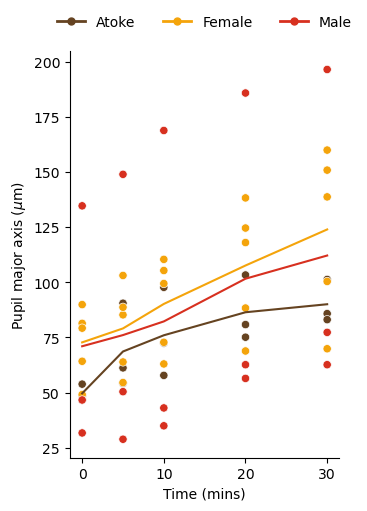

In [140]:
# Ensure 'group' is a categorical variable and matches the group_colors dictionary keys
eye_measures_um_df['group'] = eye_measures_um_df['group'].astype('category')

# Create a relplot with increased width
g = sns.relplot(data=eye_measures_um_df, x='time', y='major', hue='group', height=4.8, aspect=0.75, palette=group_colors)

# Add a lineplot on the relplot using the group_colors dictionary
g.map_dataframe(sns.lineplot, 'time', 'major', hue='group', estimator='mean', err_style=None, palette=group_colors)

# Remove the original legend
g._legend.remove()

# Define custom legend handles using the group_colors palette
legend_handles = [Line2D([0], [0], color=group_colors[group], marker='o', markersize=5, linestyle='-', linewidth=2) for group in ['atoke', 'female', 'male']]

# Add a new legend with custom handles and no outer box
plt.legend(handles=legend_handles, labels=['Atoke', 'Female', 'Male'], loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3, frameon=False)

# Set axis labels
plt.xlabel('Time (mins)')
plt.ylabel(r'Pupil major axis ($\mu$m)')

# Show the plot
plt.show()

There is one male outlier which far exceeds all other data.

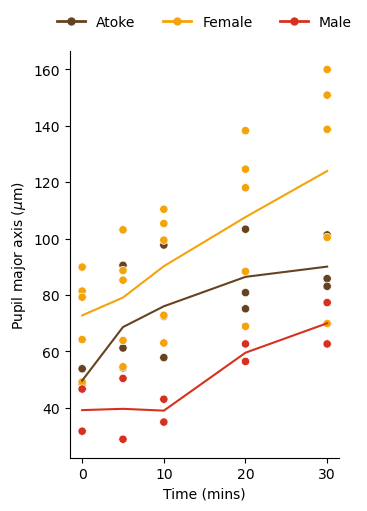

In [141]:
eye_measures_um_df = eye_measures_um_df.loc[eye_measures_um_df['id'] != 'male2'].copy()

# Ensure 'group' is a categorical variable and matches the group_colors dictionary keys
eye_measures_um_df['group'] = eye_measures_um_df['group'].astype('category')

# Create a relplot with increased width
g = sns.relplot(data=eye_measures_um_df, x='time', y='major', hue='group', height=4.8, aspect=0.75, palette=group_colors)

# Add a lineplot on the relplot using the group_colors dictionary
g.map_dataframe(sns.lineplot, 'time', 'major', hue='group', estimator='mean', err_style=None, palette=group_colors)

# Remove the original legend
g._legend.remove()

# Define custom legend handles using the group_colors palette
legend_handles = [Line2D([0], [0], color=group_colors[group], marker='o', markersize=5, linestyle='-', linewidth=2) for group in ['atoke', 'female', 'male']]

# Add a new legend with custom handles and no outer box
plt.legend(handles=legend_handles, labels=['Atoke', 'Female', 'Male'], loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3, frameon=False)

# Set axis labels
plt.xlabel('Time (mins)')
plt.ylabel(r'Pupil major axis ($\mu$m)')

# Show the plot
plt.show()

In [142]:
# Convert to micrometers
# Factor 'major', 'minor', 'feret', and 'minFeret' by 0.55
eye_measures_um_df[['major', 'minor', 'feret', 'minFeret']] *= 100/182
eye_measures_um_df.tail()

,group,id,side,time,area,perimeter,major,minor,feret,minFeret
50,male,male3,only,0,1495,151.938,25.653846,22.400549,25.917582,22.420879
51,male,male3,only,5,1621,168.977,27.722527,22.475824,28.497253,21.978022
52,male,male3,only,10,1210,140.741,23.673077,19.647253,25.050000,20.329670
53,male,male3,only,20,2593,207.954,34.435165,28.944505,34.580220,28.021978
54,male,male3,only,30,2593,207.954,34.435165,28.944505,34.580220,28.021978


In [143]:
# Select numeric columns excluding 'time'
numeric_cols = eye_measures_um_df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('time')

# Check for existing combinations of 'group' and 'id'
existing_combinations = eye_measures_um_df[['group', 'id']].drop_duplicates()

# Group by 'time', 'group', 'id', and calculate mean of numeric columns
eye_measures_um_df_grouped = (
    eye_measures_um_df.groupby(['time', 'group', 'id'], as_index=False)[numeric_cols].mean()
)

# Ensure the result only contains existing 'group' and 'id' combinations, and no new combinations are introduced
eye_measures_um_df_grouped = eye_measures_um_df_grouped.merge(existing_combinations, on=['group', 'id'])

# Verify the result
eye_measures_um_df_grouped.head()

C:\Users\seano\AppData\Local\Temp\ipykernel_18752\3078834360.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eye_measures_um_df.groupby(['time', 'group', 'id'], as_index=False)[numeric_cols].mean()


,time,group,id,area,perimeter,major,minor,feret,minFeret
0,0,atoke,atoke1,1514.0,151.037,26.625275,21.857143,27.180220,22.005495
1,0,atoke,atoke2,1504.0,158.066,29.600000,19.531319,29.263187,19.419780
2,0,atoke,atoke3,1495.0,151.938,25.653846,22.400549,25.917582,22.420879
3,0,female,female1,4255.0,265.497,44.726374,36.568132,46.482967,37.515385
4,0,female,female2,4142.0,263.312,46.466209,33.796429,48.273077,34.890110


In [144]:
# Display the first few rows of the dataframe
eye_measures_um_df['W_scaled'] = (eye_measures_um_df['major'] - eye_measures_um_df['major'].mean()) / eye_measures_um_df['major'].std()
eye_measures_um_df['T_scaled'] = (eye_measures_um_df['time'] - eye_measures_um_df['time'].mean()) / eye_measures_um_df['time'].std()
eye_measures_um_df.head()

,group,id,side,time,area,perimeter,major,minor,feret,minFeret,W_scaled,T_scaled
0,atoke,atoke1,only,0,1514,151.037,26.625275,21.857143,27.180220,22.005495,-1.026982,-1.194889
1,atoke,atoke1,only,5,1163,143.788,29.782418,15.009890,29.127473,14.762637,-0.836970,-0.735316
2,atoke,atoke1,only,10,1494,156.100,31.775824,18.072527,32.135165,18.543956,-0.716997,-0.275744
3,atoke,atoke1,only,20,2856,242.592,41.279670,26.594505,42.067582,26.923077,-0.145011,0.643402
4,atoke,atoke1,only,30,3685,245.406,47.148352,30.042857,47.092857,30.219780,0.208193,1.562547


In [145]:
eye_measures_um_df.describe()

,time,area,perimeter,major,minor,feret,minFeret,W_scaled,T_scaled
count,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,5.000000e+01
mean,13.000000,4532.58000,247.473360,43.689110,34.710736,44.633165,34.977385,-6.705747e-16,2.220446e-17
std,10.879676,3630.14959,95.793219,16.615519,14.657032,16.994427,14.825278,1.000000e+00,1.000000e+00
min,0.000000,544.00000,87.993000,15.882418,11.984615,15.934066,12.087912,-1.673537e+00,-1.194889e+00
25%,5.000000,1858.25000,172.130750,31.212500,22.894918,32.181319,23.369780,-7.509010e-01,-7.353160e-01
50%,10.000000,3321.00000,236.414000,41.881044,31.221978,43.177747,31.962637,-1.088179e-01,-2.757435e-01
75%,20.000000,6265.25000,304.259500,54.403022,43.420192,55.521566,43.993132,6.448136e-01,6.434015e-01
max,30.000000,15963.00000,486.321000,87.858242,69.839560,88.815934,69.230769,2.658306e+00,1.562547e+00


In [146]:
with pm.Model() as m1:
    # Convert 'Group' to an integer category
    eye_measures_um_df['group_idx'] = eye_measures_um_df['group'].astype('category').cat.codes

    # Priors
    Intercept = pm.Normal('Intercept', mu=0, sigma=1, shape=eye_measures_um_df['group_idx'].nunique())
    Slope = pm.Normal('Slope', mu=0, sigma=1, shape=eye_measures_um_df['group_idx'].nunique())
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model
    mu = Intercept[eye_measures_um_df['group_idx']] + Slope[eye_measures_um_df['group_idx']] * eye_measures_um_df['T_scaled']

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=eye_measures_um_df['W_scaled'])

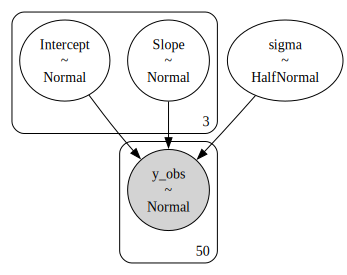

In [147]:
# Need graphviz to view the model
pm.model_to_graphviz(m1)

Sampling: [Intercept, Slope, sigma, y_obs]


<Axes: xlabel='y_obs'>

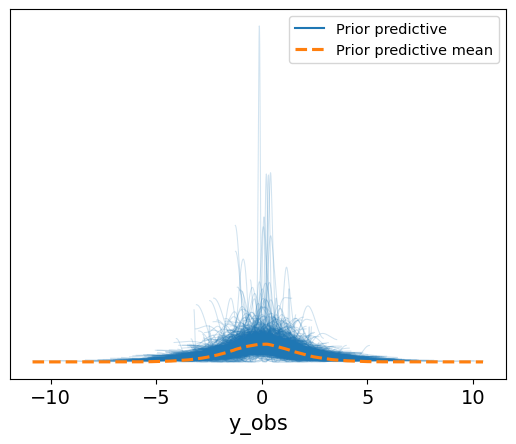

In [149]:
# PRIOR PREDICTIVE CHECK
with m1:
    idata = pm.sample_prior_predictive(samples=1000, random_seed=rng)

az.plot_ppc(idata, group="prior", kind="kde", data_pairs={"y_obs": "y_obs"})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Slope, sigma]


Output()

Sampling 4 chains for 2_500 tune and 2_500 draw iterations (10_000 + 10_000 draws total) took 31 seconds.


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'Slope'}>,
        <Axes: title={'center': 'Slope'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

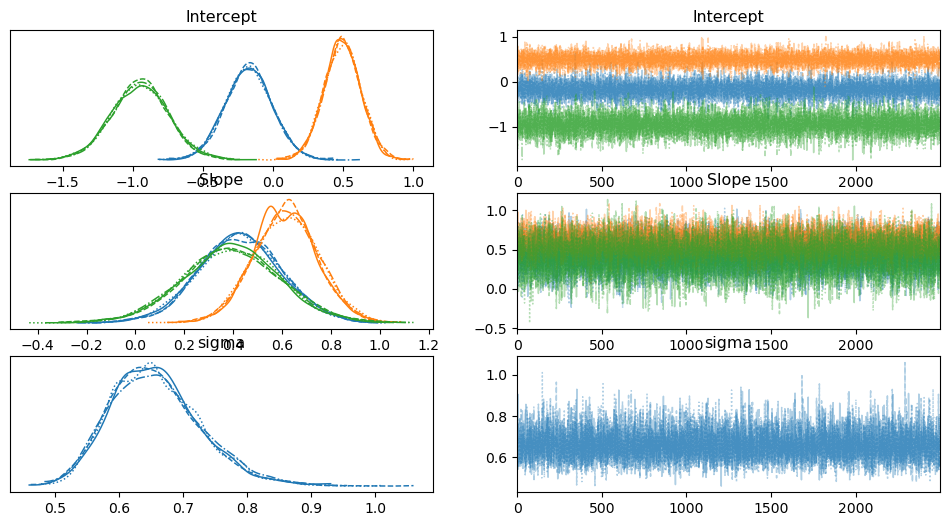

In [150]:
with m1:
    idata.extend(pm.sample(ndraws, tune=ntune, random_seed=rng))

az.plot_trace(idata)

Sampling: [y_obs]


Output()

Sampling: [y_obs]


Output()

<Axes: xlabel='y_obs'>

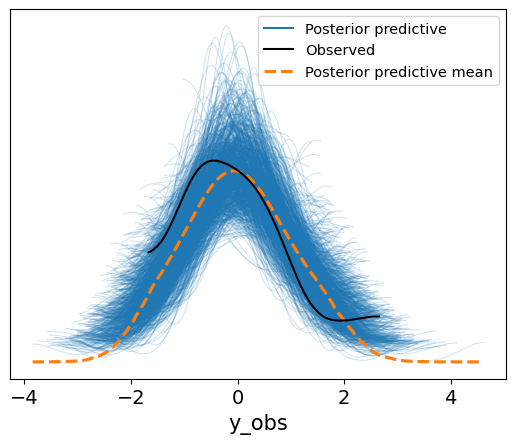

In [151]:
# POSTERIOR PREDICTIVE CHECK
with m1:
   idata.extend(pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng, predictions= True))
   idata.extend(pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng, predictions= False))

az.plot_ppc(idata, group="posterior", kind="kde", data_pairs={"y_obs": "y_obs"}, num_pp_samples=1000)

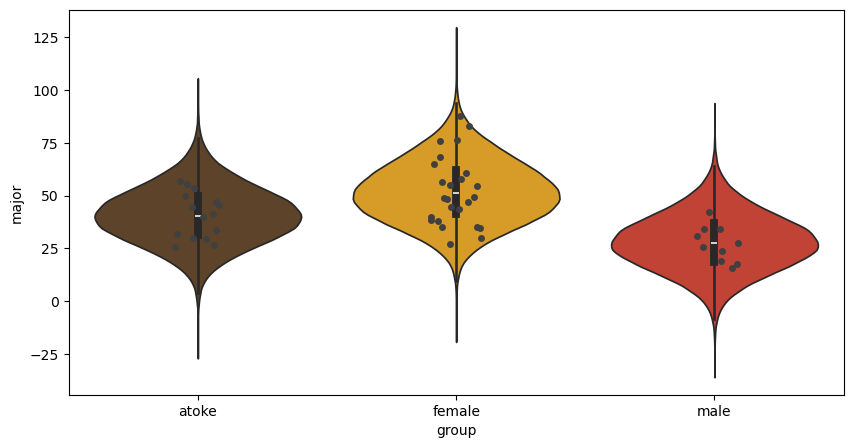

In [154]:
major_mean = eye_measures_um_df['major'].mean() 
major_std   = eye_measures_um_df['major'].std()

Groups = eye_measures_um_df['group']

# Convert 'y_obs' to a numpy array and reshape to 2 dimensions
y_obs_2d = idata.posterior_predictive['y_obs'].values.reshape(-1, len(Groups))

# Convert posterior predictive samples into a DataFrame
ppc_df = pd.DataFrame(y_obs_2d, columns=Groups)

# Take the mean of the predictions for each 'Group'
ppc_df_mean = ppc_df.groupby(level=0).mean()

# Melt the DataFrame to long format for plotting
ppc_df_melt = ppc_df_mean.melt(var_name='group', value_name='Predicted_W')
ppc_df_melt['major'] = (ppc_df_melt['Predicted_W'] * major_std) + major_mean

# Plot boxplots
plt.figure(figsize=(10, 5))
sns.violinplot(data=ppc_df_melt, x='group', y='major', hue='group', palette= group_colors)
sns.stripplot(data=eye_measures_um_df, x="group", y="major", color="0.25")
plt.show()